In [35]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import pandas as pd
from datetime import datetime as dt
from matplotlib import pyplot as plt
from datetime import datetime

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
date_time_format = '%Y/%m/%d %H:%M:%S'
# df = pd.read_csv('connection_2019.csv', delimiter = ';')
def preprocess(data):
#     data = pd.read_csv(filename, sep = delimiter)
    data['EVENT_PURPOSE'] = data['EVENT_C'] + '_' + data['DERIVED_CNTR_PURP_C']
    
    # data["BTR1_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.BTR1]
    data["ATD1_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATD1]
    # data["ATU1_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATU1]
    # data["BTR2_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.BTR2]
    # data["ATD2_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATD2]
    # data["ATU2_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATU2]
    
    data['DIFF_ATD1_BTR1'] = [(dt.strptime(row['ATD1'], date_time_format) - dt.strptime(row['BTR1'], date_time_format)).total_seconds() / 60 \
                          for index, row in data.iterrows()]
    data['DIFF_ATU1_ATD1'] = [(dt.strptime(row['ATU1'], date_time_format) - dt.strptime(row['ATD1'], date_time_format)).total_seconds() / 60 \
                              for index, row in data.iterrows()]
    #data['DIFF_ATD2_BTR2'] = [(dt.strptime(row['ATD2'], date_time_format) - dt.strptime(row['BTR2'], date_time_format)).total_seconds() / 60 \
    #                          for index, row in data.iterrows() if not pd.isna(row['BTR2']) and not pd.isna(row['ATD2'])]
    #data['DIFF_ATU2_ATD2'] = [(dt.strptime(row['ATU2'], date_time_format) - dt.strptime(row['ATD2'], date_time_format)).total_seconds() / 60 \
    #                          for index, row in data.iterrows() if not pd.isna(row['ATU2']) and not pd.isna(row['ATD2'])]
    
    #data['DIFF_ATU2_ATD1'] = [(dt.strptime(row['ATU2'], date_time_format) - dt.strptime(row['ATD1'], date_time_format)).total_seconds() / 60 \
    #                      for index, row in data.iterrows() if not pd.isna(row['ATU2'])]
    
    data = data.drop(columns = ['EVENT_C', 'ABBR_VESSEL_M1', 'BTR1', 'ATD1', 'ATU1', 'SERVICE_TYPE_DESC_X1', \
                            'CONSORTIUM_C1', 'ABBR_VESSEL_M2', 'BTR2', 'ATD2', 'ATU2', 'SERVICE_TYPE_DESC_X2', \
                            'CONSORTIUM_C2', 'OPR_GROUP_C', 'SUMOFBOX_Q'])
    return data
# df = preprocess(df)

In [2]:
df19 = pd.read_csv('connection_2019_preprocessed.csv')
df18 = pd.read_csv('connection_2018_preprocessed.csv')
df17 = pd.read_csv('connection_2017_preprocessed.csv')

In [3]:
df.to_csv('connection_2019_preprocessed.csv', index=False)

In [3]:
combine = pd.concat([df17, df18, df19], ignore_index=True)

In [ ]:
combine.EVENT_PURPOSE.unique()

In [52]:
combine.DERIVED_CNTR_PURP_C.unique()

array(['TSHIP', 'LRSHP', 'IMPT', 'EXPT', 'REXPT'], dtype=object)

# TSHIP

In [5]:
tship1 = combine[combine['EVENT_PURPOSE'] == 'LOAD_TSHIP']
tship2 = combine[combine['EVENT_PURPOSE'] == 'DISC_TSHIP']
tship = pd.concat([tship1, tship2])
print(tship1.shape)
print(tship2.shape)
print(tship.shape)

tship_sorted = tship.sort_values(by = 'ATD1_DATE')
tship_sorted = tship_sorted.set_index('ATD1_DATE')

date_rng = pd.date_range(start = '2017-01-01', end = '2019-12-31')
string_date_rng = tship_sorted.index.tolist()

timestamp_date_tship = pd.to_datetime(string_date_rng, infer_datetime_format = True)
tship_sorted.index = timestamp_date_tship

teu_by_day_tship = tship_sorted['SUMOFTEU_Q'].resample('D').sum()

(4211344, 21)
(4198935, 21)
(8410279, 21)


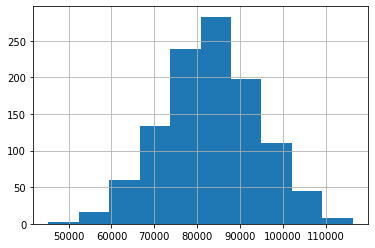

In [8]:
# distribution summary plot
teu_by_day_tship.hist()
plt.show()

In [39]:
# fit model
train_size = int(len(teu_by_day_tship) * 0.666) 
train, test = teu_by_day_tship[0:train_size], teu_by_day_tship[train_size:]

history = [x for x in train]

model = ARIMA(train, order=(3,1,7))
model_fit = model.fit()

# summary of fit model
# print(model_fit.summary())

predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,7))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
mae = mean_absolute_error(test, predictions)
print(mae) #7477.019163495437

# line plot of residuals
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()

# density plot of residuals
# residuals.plot(kind='kde')
# plt.show()

# summary stats of residuals
# print(residuals.describe())

In [23]:
# fit model with same train, test but using order (2,1,7)
history = [x for x in train]
train_size = int(len(teu_by_day_tship) * 0.666) 
train, test = teu_by_day_tship[0:train_size], teu_by_day_tship[train_size:]

predictions2 = list()
for t in range(len(test)):
    model2 = ARIMA(history, order=(2,1,7))
    model_fit2 = model2.fit()
    yhat2 = model_fit2.forecast()[0]
    predictions2.append(yhat2)
    history.append(test[t])

# calculate out of sample error
mae = mean_absolute_error(test, predictions)
print(mae) #7477.019163495437

7477.019163495437


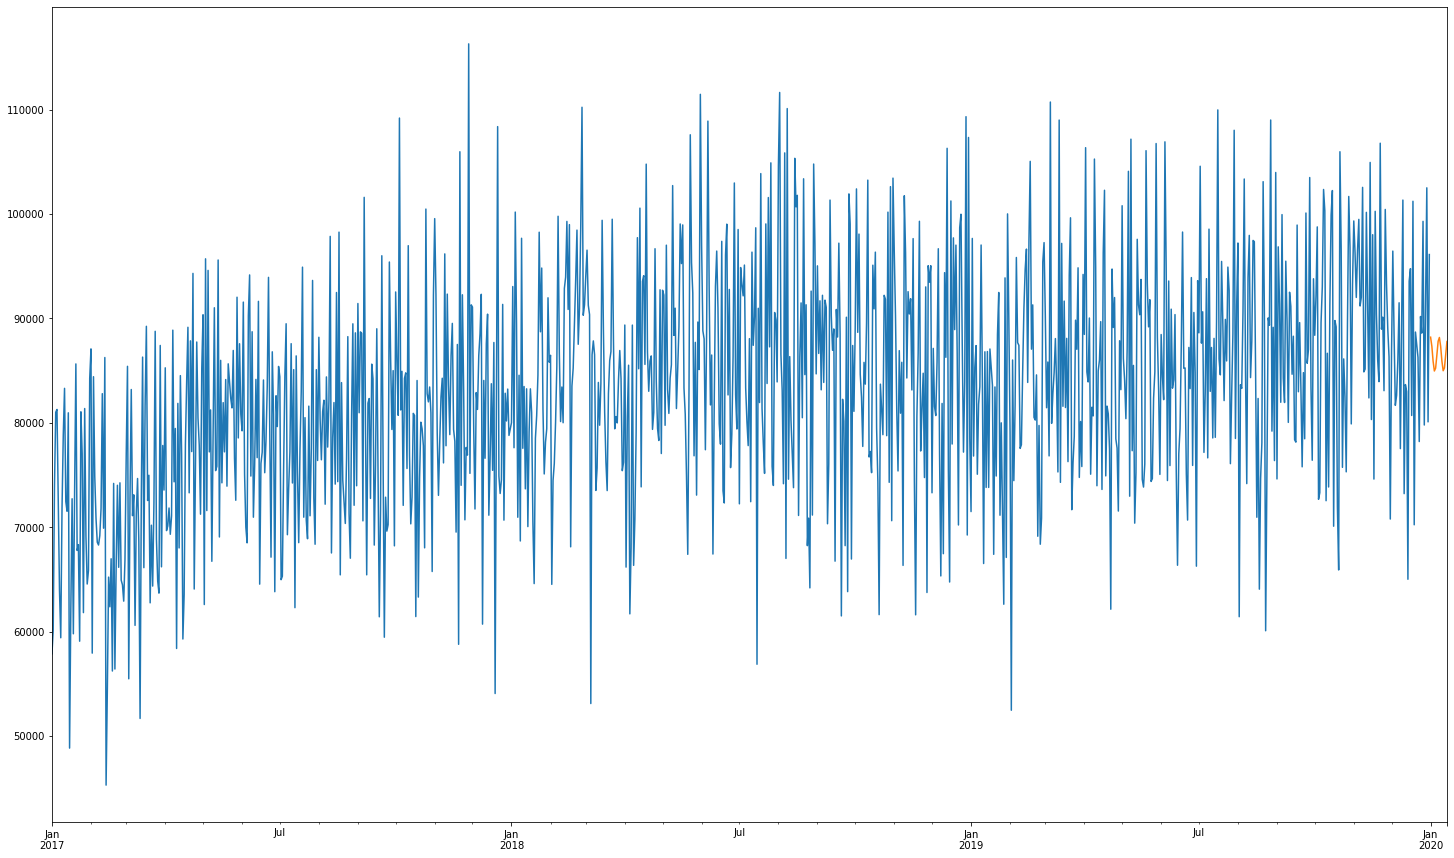

In [45]:
start_index = datetime(2020, 1, 1)
end_index = datetime(2020, 1, 14)
forecast = model_fit.predict(start=start_index, end=end_index)
plt.figure(figsize=(25,15))
teu_by_day_tship.plot()
forecast.plot()
plt.show()

# LRSHP

In [47]:
lrshp = combine[combine['DERIVED_CNTR_PURP_C'] == 'LRSHP']

lrshp_sorted = lrshp.sort_values(by = 'ATD1_DATE')

lrshp_sorted = lrshp_sorted.set_index('ATD1_DATE')

date_rng = pd.date_range(start = '2017-01-01', end = '2019-12-31')
string_date_rng = lrshp_sorted.index.tolist()

timestamp_date_lrshp = pd.to_datetime(string_date_rng, infer_datetime_format = True)
lrshp_sorted.index = timestamp_date_lrshp

teu_by_day_lrshp = lrshp_sorted['SUMOFTEU_Q'].resample('D').sum()

1675.730128934112


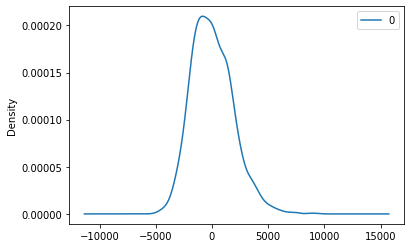

In [50]:
# fit model
train_size = int(len(teu_by_day_lrshp) * 0.666) 
train, test = teu_by_day_lrshp[0:train_size], teu_by_day_lrshp[train_size:]

history = [x for x in train]

lrshp_model = ARIMA(train, order=(3,1,7))
lrshp_model_fit = lrshp_model.fit()

# summary of fit model
# print(model_fit.summary())

predictions = list()
for t in range(len(test)):
    lrshp_model = ARIMA(history, order=(3,1,7))
    lrshp_model_fit = lrshp_model.fit()
    yhat = lrshp_model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
    
# calculate out of sample error
mae = mean_absolute_error(test, predictions)
print(mae)  #1675.730128934112

# line plot of residuals
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
# print(residuals.describe())

In [51]:
print(mae) 

1675.730128934112


In [56]:
lrshp_model = ARIMA(teu_by_day_lrshp, order=(3,1,7))
lrshp_model_fit = lrshp_model.fit()

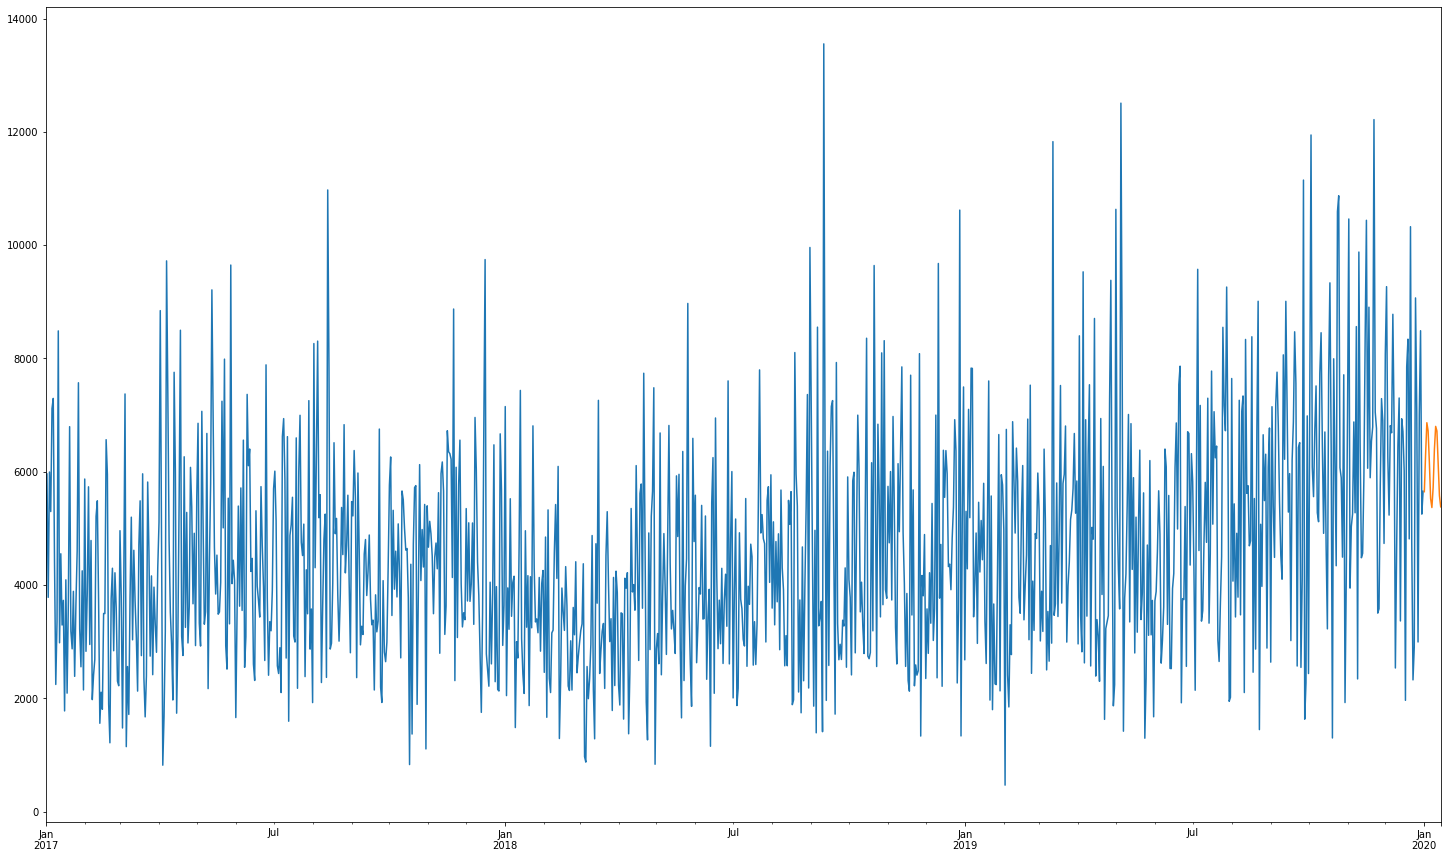

In [57]:
start_index = datetime(2020, 1, 1)
end_index = datetime(2020, 1, 14)
forecast = lrshp_model_fit.predict(start=start_index, end=end_index)
plt.figure(figsize=(25,15))
teu_by_day_lrshp.plot()
forecast.plot()
plt.show()

# IMPT

In [59]:
impt = combine[combine['DERIVED_CNTR_PURP_C'] == 'IMPT']

impt_sorted = impt.sort_values(by = 'ATD1_DATE')

impt_sorted = impt_sorted.set_index('ATD1_DATE')

date_rng = pd.date_range(start = '2017-01-01', end = '2019-12-31')
string_date_rng = impt_sorted.index.tolist()

timestamp_date_impt = pd.to_datetime(string_date_rng, infer_datetime_format = True)
impt_sorted.index = timestamp_date_impt

teu_by_day_impt = impt_sorted['SUMOFTEU_Q'].resample('D').sum()

799.9552892195802


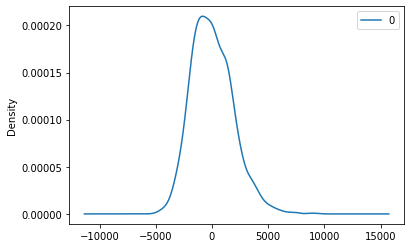

In [60]:
# fit model
train_size = int(len(teu_by_day_impt) * 0.666) 
train, test = teu_by_day_impt[0:train_size], teu_by_day_impt[train_size:]

history = [x for x in train]

impt_model = ARIMA(train, order=(3,1,7))
impt_model_fit = impt_model.fit()

# summary of fit model
# print(model_fit.summary())

predictions = list()
for t in range(len(test)):
    impt_model = ARIMA(history, order=(3,1,7))
    impt_model_fit = impt_model.fit()
    yhat = impt_model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
    
# calculate out of sample error
mae = mean_absolute_error(test, predictions)
print(mae) 

# line plot of residuals
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
# print(residuals.describe())

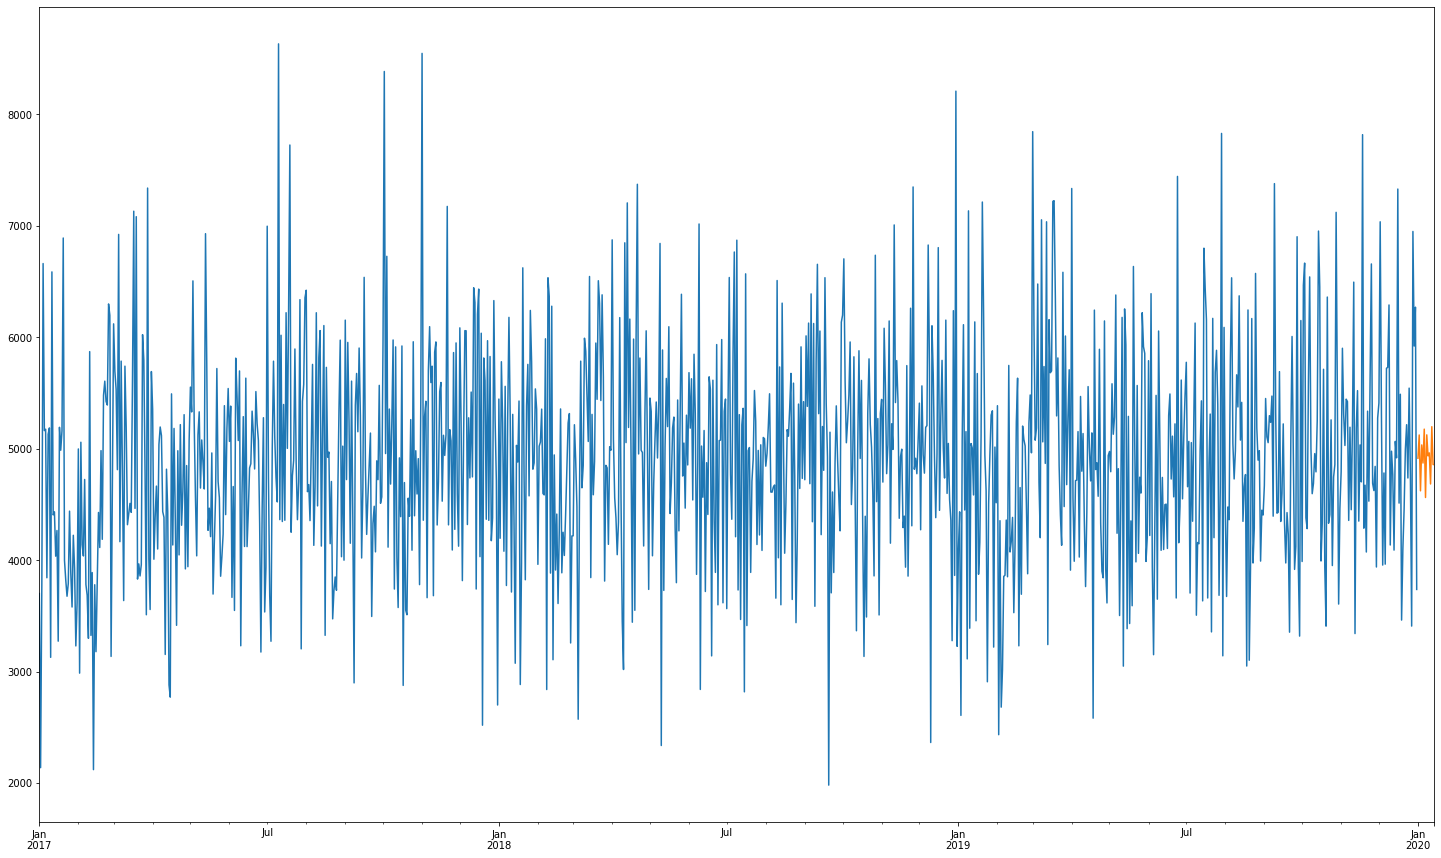

In [62]:
impt_model = ARIMA(teu_by_day_impt, order=(3,1,7))
impt_model_fit = impt_model.fit()

start_index = datetime(2020, 1, 1)
end_index = datetime(2020, 1, 14)
forecast = impt_model_fit.predict(start=start_index, end=end_index)
plt.figure(figsize=(25,15))
teu_by_day_impt.plot()
forecast.plot()
plt.show()

In [ ]:
# 'EXPT', 'REXPT'

In [67]:
expt = combine[combine['DERIVED_CNTR_PURP_C'] == 'EXPT']

expt_sorted = expt.sort_values(by = 'ATD1_DATE')

expt_sorted = expt_sorted.set_index('ATD1_DATE')

date_rng = pd.date_range(start = '2017-01-01', end = '2019-12-31')
string_date_rng = expt_sorted.index.tolist()

timestamp_date_expt = pd.to_datetime(string_date_rng, infer_datetime_format = True)
expt_sorted.index = timestamp_date_expt

teu_by_day_expt = expt_sorted['SUMOFTEU_Q'].resample('D').sum()

625.7799269834402


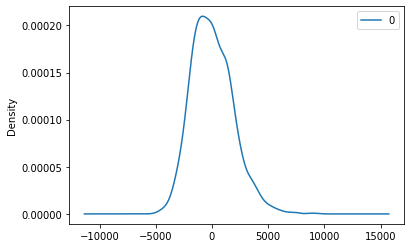

In [69]:
# fit model
train_size = int(len(teu_by_day_expt) * 0.666) 
train, test = teu_by_day_expt[0:train_size], teu_by_day_expt[train_size:]

history = [x for x in train]

expt_model = ARIMA(train, order=(3,1,7))
expt_model_fit = expt_model.fit()

# summary of fit model
# print(model_fit.summary())

predictions = list()
for t in range(len(test)):
    expt_model = ARIMA(history, order=(3,1,7))
    expt_model_fit = expt_model.fit()
    yhat = expt_model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
    
# calculate out of sample error
mae = mean_absolute_error(test, predictions)
print(mae) 

# line plot of residuals
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()


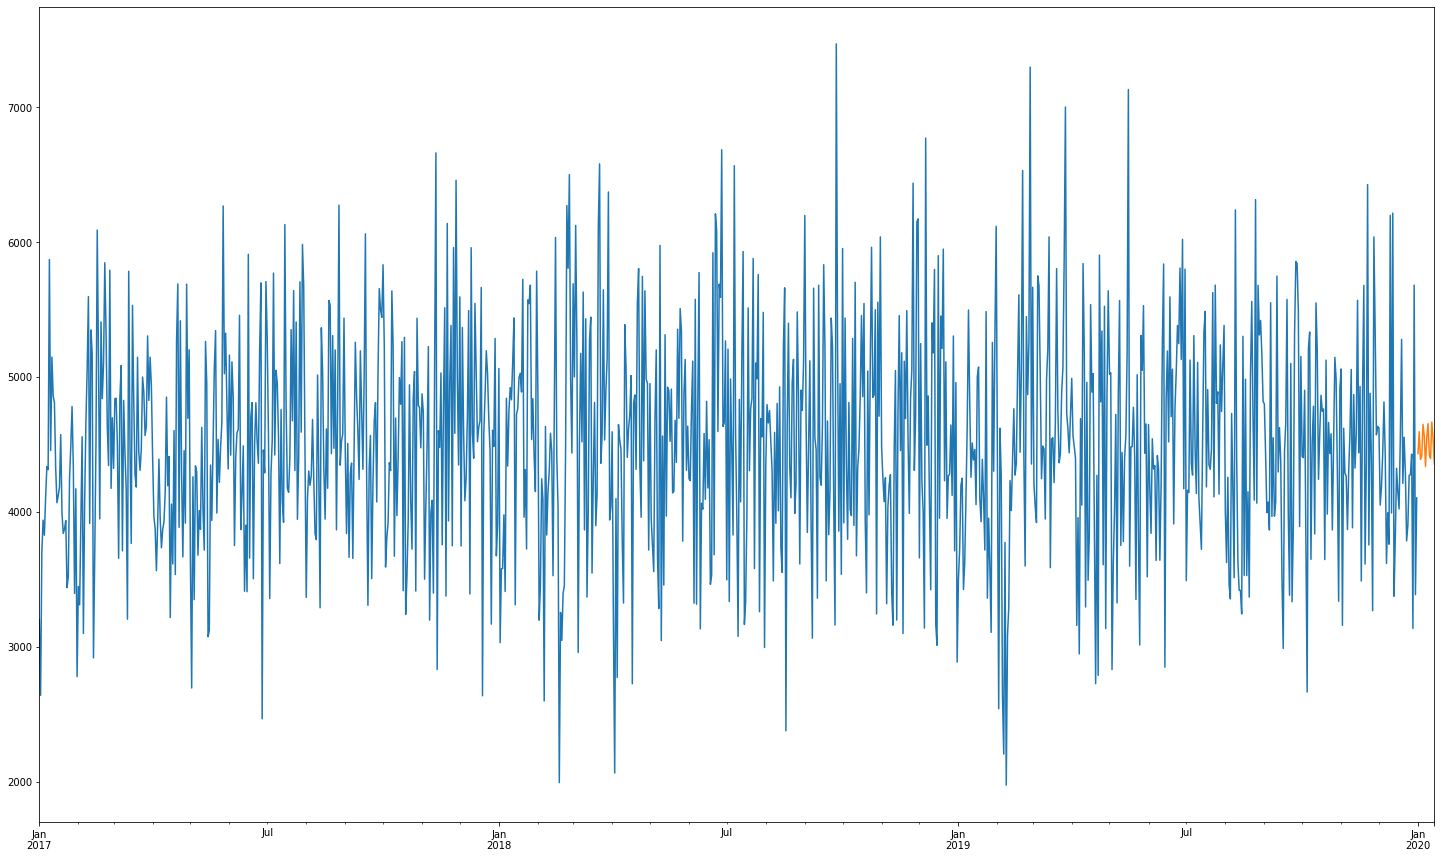

In [71]:
expt_model = ARIMA(teu_by_day_expt, order=(3,1,7))
expt_model_fit = expt_model.fit()

start_index = datetime(2020, 1, 1)
end_index = datetime(2020, 1, 14)
forecast = expt_model_fit.predict(start=start_index, end=end_index)
plt.figure(figsize=(25,15))
teu_by_day_expt.plot()
forecast.plot()
plt.show()


In [68]:
rexpt = combine[combine['DERIVED_CNTR_PURP_C'] == 'REXPT']

rexpt_sorted = rexpt.sort_values(by = 'ATD1_DATE')

rexpt_sorted = rexpt_sorted.set_index('ATD1_DATE')

date_rng = pd.date_range(start = '2017-01-01', end = '2019-12-31')
string_date_rng = rexpt_sorted.index.tolist()

timestamp_date_rexpt = pd.to_datetime(string_date_rng, infer_datetime_format = True)
rexpt_sorted.index = timestamp_date_rexpt

teu_by_day_rexpt = rexpt_sorted['SUMOFTEU_Q'].resample('D').sum()

40.43926313288987


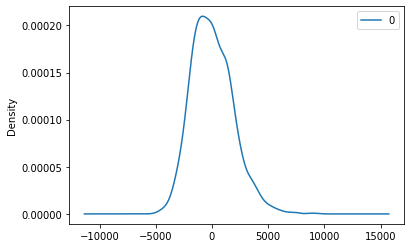

In [70]:
# fit model
train_size = int(len(teu_by_day_rexpt) * 0.666) 
train, test = teu_by_day_rexpt[0:train_size], teu_by_day_rexpt[train_size:]

history = [x for x in train]

rexpt_model = ARIMA(train, order=(3,1,7))
rexpt_model_fit = rexpt_model.fit()

# summary of fit model
# print(model_fit.summary())

predictions = list()
for t in range(len(test)):
    rexpt_model = ARIMA(history, order=(3,1,7))
    rexpt_model_fit = rexpt_model.fit()
    yhat = rexpt_model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
    
# calculate out of sample error
mae = mean_absolute_error(test, predictions)
print(mae) 

# line plot of residuals
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()


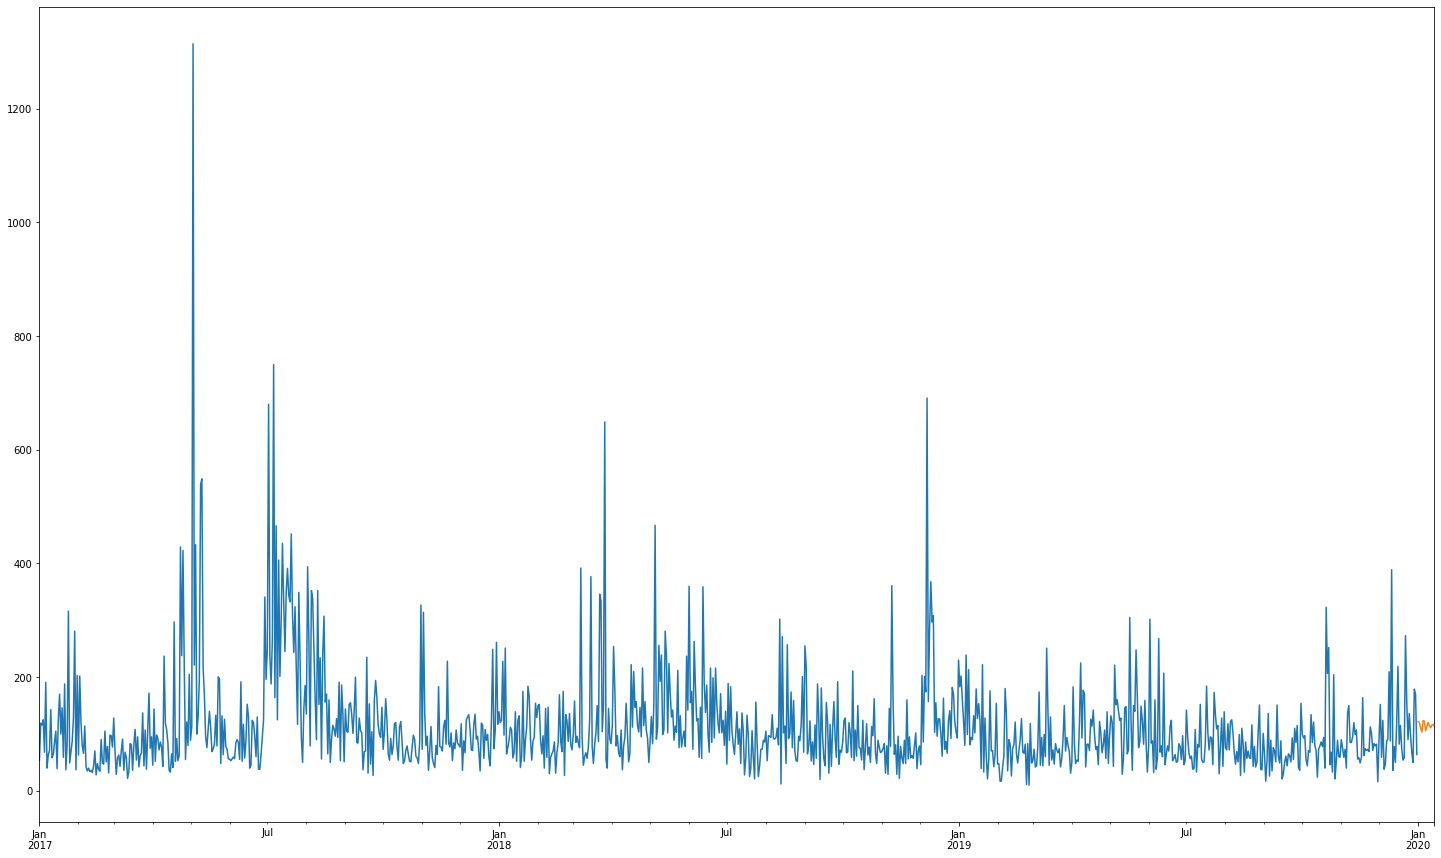

In [72]:
rexpt_model = ARIMA(teu_by_day_rexpt, order=(3,1,7))
rexpt_model_fit = rexpt_model.fit()

start_index = datetime(2020, 1, 1)
end_index = datetime(2020, 1, 14)
forecast = rexpt_model_fit.predict(start=start_index, end=end_index)
plt.figure(figsize=(25,15))
teu_by_day_rexpt.plot()
forecast.plot()
plt.show()


#EDA

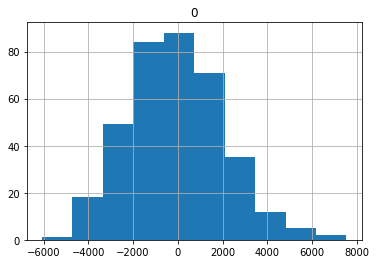

In [26]:
# residual distribution plot
residuals.hist()
pyplot.show()

In [72]:
#adfuller test for stationarity
#reference: https://machinelearningmastery.com/time-series-data-stationary-python/
from statsmodels.tsa.stattools import adfuller
result = adfuller(teu_by_day_tship)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.181638
p-value: 0.021072
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [27]:
result = adfuller(residuals)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.516851
p-value: 0.000183
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [37]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(teu_by_day, nlags=20)
lag_pacf = pacf(teu_by_day, nlags=20, method='ols')

In [41]:
import numpy as np

Text(0.5, 1.0, 'RSS: 1708577496.9023')

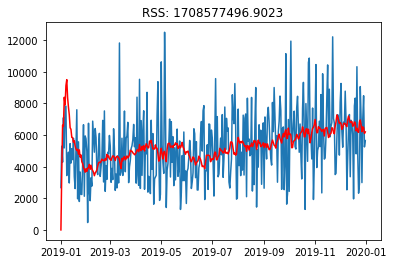

In [47]:
# reference: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
model = ARIMA(teu_by_day, order=(1,2,7))
results_ARIMA = model.fit()
plt.plot(teu_by_day)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-teu_by_day)**2))

conclusion: the lrshp for 2019 and residuals upon fitting the model is a stationary time series

Forecasting, reference: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = 99999999, None
    output = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(order)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        output.append((order, mse))
                        print('(BETTER) ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    print('evaluation failed')
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return output

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 2)
q_values = [0,1,2,7]
modelperformances = evaluate_models(teu_by_day_tship, p_values, d_values, q_values)

(0, 0, 0)
(BETTER) ARIMA(0, 0, 0) MSE=10962.853
(0, 0, 1)
(BETTER) ARIMA(0, 0, 1) MSE=10943.140
(0, 0, 2)
(BETTER) ARIMA(0, 0, 2) MSE=10923.547
(0, 0, 7)
(BETTER) ARIMA(0, 0, 7) MSE=10384.602
(0, 1, 0)
(0, 1, 1)
(BETTER) ARIMA(0, 1, 1) MSE=10295.350
(0, 1, 2)
(BETTER) ARIMA(0, 1, 2) MSE=10279.408
(0, 1, 7)
(BETTER) ARIMA(0, 1, 7) MSE=10193.630
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 7)
(BETTER) ARIMA(1, 0, 7) MSE=10173.634
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 1, 7)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 7)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 1, 7)
(BETTER) ARIMA(2, 1, 7) MSE=9714.661
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 0, 7)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 1, 7)
(BETTER) ARIMA(3, 1, 7) MSE=9586.258
(4, 0, 0)
(4, 0, 1)
(4, 0, 2)
(4, 0, 7)
evaluation failed
(4, 1, 0)
